# Latihan Membuat Machine Learning Pipeline

In [1]:
import tensorflow as tf
from tfx.components import CsvExampleGen, StatisticsGen, SchemaGen, ExampleValidator, Transform, Trainer, Tuner, Pusher
from tfx.proto import example_gen_pb2, trainer_pb2, pusher_pb2
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
import os

from tfx.dsl.components.common.resolver import Resolver 
from tfx.dsl.input_resolution.strategies.latest_blessed_model_strategy import LatestBlessedModelStrategy 
from tfx.types import Channel 
from tfx.types.standard_artifacts import Model, ModelBlessing 

import tensorflow_model_analysis as tfma 
from tfx.components import Evaluator

#added by me
import tensorflow_transform as tft 
import logging
from absl import logging
from tfx.v1.components import FnArgs

import pandas as pd
import numpy as np

## Set Variable

In [2]:
PIPELINE_NAME = "hadezbladez-pipeline"
SCHEMA_PIPELINE_NAME = "skincancer-tfdv-schema"

#Directory untuk menyimpan artifact yang akan dihasilkan
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)

# Path to a SQLite DB file to use as an MLMD storage.
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'metadata.db')

# Output directory where created models from the pipeline will be exported.
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)

## add more
TRANSFORM_MODULE_FILE = "skincancer_transform.py"
TRAINER_MODULE_FILE = "skincancer_trainer.py"

PUSHED_MODEL_PATH = './serving_model_dir_skincancer/skincancer-detection-model'

In [3]:
DATA_ROOT = "data"

In [4]:
interactive_context = InteractiveContext(pipeline_root=PIPELINE_ROOT)

---- ADDED MORE BY ME

In [5]:
output = example_gen_pb2.Output(
    split_config = example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name="train", hash_buckets=8),
        example_gen_pb2.SplitConfig.Split(name="eval", hash_buckets=2)
    ])
)
example_gen = CsvExampleGen(input_base=DATA_ROOT, output_config=output)
interactive_context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

In [6]:
# summary statistic
statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])
interactive_context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

In [7]:
interactive_context.show(statistics_gen.outputs['statistics'] )

In [8]:
schema_gen = SchemaGen(statistics=statistics_gen.outputs['statistics'])
interactive_context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}))

In [9]:
interactive_context.show(schema_gen.outputs["schema"])

,Type,Presence,Valency,Domain
Feature name,,,,
'age',FLOAT,required,,-
'dx',STRING,required,,'dx'
'dx_type',STRING,required,,'dx_type'
'image_id',BYTES,required,,-
'lesion_id',BYTES,required,,-
'localization',STRING,required,,'localization'
'sex',STRING,required,,'sex'


,Values
Domain,
'dx',"'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'"
'dx_type',"'confocal', 'consensus', 'follow_up', 'histo'"
'localization',"'abdomen', 'acral', 'back', 'chest', 'ear', 'face', 'foot', 'genital', 'hand', 'lower extremity', 'neck', 'scalp', 'trunk', 'unknown', 'upper extremity'"
'sex',"'female', 'male', 'unknown'"


In [10]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema']
)
interactive_context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}))

In [11]:
interactive_context.show(example_validator.outputs['anomalies'])

In [12]:
%%writefile {TRANSFORM_MODULE_FILE}
import tensorflow as tf
import tensorflow_transform as tft

LABEL_KEY = "dx"
NUMERIC_FEATURE_KEYS = ["age"]
CATEGORICAL_FEATURE_KEYS = ["sex", "localization"]
ALL_FEATURE_KEYS = NUMERIC_FEATURE_KEYS + CATEGORICAL_FEATURE_KEYS
NUM_OOV_BUCKETS = 1

def transformed_name(key):
    """Renaming transformed features"""
    return key + "_xf"
def preprocessing_fn(inputs):
    """
    Preprocess input features into transformed features
    
    Args:
        inputs: map from feature keys to raw features.
    
    Return:
        outputs: map from feature keys to transformed features.    
    """
    
    outputs = {}
    
    for key in NUMERIC_FEATURE_KEYS:#
        outputs[transformed_name(key)] = tft.sparse_tensor_to_dense_with_shape(
                x=tf.cast(inputs[key], tf.int64), shape=[None, 1]
        )
#         outputs[transformed_name(key)] = tft.sparse_tensor_to_dense_with_shape(
#                 x=tft.scale_to_0_1(inputs[key]), shape=[None, 1]
#         )
        print(f"key{transformed_name(key)}", outputs[transformed_name(key)] )

    for key in CATEGORICAL_FEATURE_KEYS:
        outputs[transformed_name(key)] = tft.compute_and_apply_vocabulary(
                tf.strings.strip(inputs[key]),
                num_oov_buckets=NUM_OOV_BUCKETS,
                vocab_filename=key)
        print(f"key{transformed_name(key)}", outputs[transformed_name(key)] )
    
    # For the label column we provide the mapping from string to index.
    table_keys = ["nv", "mel", "bkl", "bcc", "akiec", "df", "vasc"]
    with tf.init_scope():
        initializer = tf.lookup.KeyValueTensorInitializer(
            keys=table_keys,
            values=tf.cast(tf.range(len(table_keys)), tf.int64),
            key_dtype=tf.string,
            value_dtype=tf.int64)
        table = tf.lookup.StaticHashTable(initializer, default_value=-1)

    # Remove trailing periods for test data when the data is read with tf.data.
    # label_str  = tf.sparse.to_dense(inputs[LABEL_KEY])
    label_str = inputs[LABEL_KEY]
    label_str = tf.strings.lower(label_str)
    data_labels = table.lookup(label_str)
    transformed_label = tf.one_hot(
          indices=data_labels, depth=len(table_keys), on_value=1.0, off_value=0.0)
    outputs[transformed_name(LABEL_KEY)] = tf.reshape(transformed_label, [-1, len(table_keys)])
    
    
    return outputs

Overwriting skincancer_transform.py


In [13]:
os.path.abspath(TRANSFORM_MODULE_FILE)

'D:\\ztoolong\\hadezbladez-pipeline\\skincancer_transform.py'

In [14]:
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema= schema_gen.outputs['schema'],
    module_file=os.path.abspath(TRANSFORM_MODULE_FILE)
)
interactive_context.run(transform)

keyage_xf Tensor("SparseToDense:0", shape=(None, 1), dtype=int64)
keysex_xf Tensor("compute_and_apply_vocabulary/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keylocalization_xf Tensor("compute_and_apply_vocabulary_1/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


keyage_xf Tensor("SparseToDense:0", shape=(None, 1), dtype=int64)
keysex_xf Tensor("compute_and_apply_vocabulary/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keylocalization_xf Tensor("compute_and_apply_vocabulary_1/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)


keyage_xf Tensor("SparseToDense:0", shape=(None, 1), dtype=int64)
keysex_xf Tensor("compute_and_apply_vocabulary/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keylocalization_xf Tensor("compute_and_apply_vocabulary_1/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keyage_xf Tensor("SparseToDense:0", shape=(None, 1), dtype=int64)
keysex_xf Tensor("compute_and_apply_vocabulary/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keylocalization_xf Tensor("compute_and_apply_vocabulary_1/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keyage_xf Tensor("SparseToDense:0", shape=(None, 1), dtype=int64)
keysex_xf Tensor("compute_and_apply_vocabulary/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)


keylocalization_xf Tensor("compute_and_apply_vocabulary_1/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keyage_xf Tensor("SparseToDense:0", shape=(None, 1), dtype=int64)
keysex_xf Tensor("compute_and_apply_vocabulary/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keylocalization_xf Tensor("compute_and_apply_vocabulary_1/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keyage_xf Tensor("SparseToDense:0", shape=(None, 1), dtype=int64)
keysex_xf Tensor("compute_and_apply_vocabulary/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keylocalization_xf Tensor("compute_and_apply_vocabulary_1/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)


keyage_xf Tensor("SparseToDense:0", shape=(None, 1), dtype=int64)
keysex_xf Tensor("compute_and_apply_vocabulary/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keylocalization_xf Tensor("compute_and_apply_vocabulary_1/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
INFO:tensorflow:Assets written to: pipelines\hadezbladez-pipeline\Transform\transform_graph\5\.temp_path\tftransform_tmp\7e988fe04cd64675a4dbd5bfb4a63e1c\assets


INFO:tensorflow:Assets written to: pipelines\hadezbladez-pipeline\Transform\transform_graph\5\.temp_path\tftransform_tmp\7e988fe04cd64675a4dbd5bfb4a63e1c\assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


keyage_xf Tensor("SparseToDense:0", shape=(None, 1), dtype=int64)
keysex_xf Tensor("compute_and_apply_vocabulary/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keylocalization_xf Tensor("compute_and_apply_vocabulary_1/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
INFO:tensorflow:Assets written to: pipelines\hadezbladez-pipeline\Transform\transform_graph\5\.temp_path\tftransform_tmp\d086b293a3444bf2b16ac8e74f803d21\assets


INFO:tensorflow:Assets written to: pipelines\hadezbladez-pipeline\Transform\transform_graph\5\.temp_path\tftransform_tmp\d086b293a3444bf2b16ac8e74f803d21\assets


keyage_xf Tensor("SparseToDense:0", shape=(None, 1), dtype=int64)
keysex_xf Tensor("compute_and_apply_vocabulary/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
keylocalization_xf Tensor("compute_and_apply_vocabulary_1/apply_vocab/None_Lookup/SelectV2:0", shape=(None, 1), dtype=int64)
INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={})
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={})
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={})
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={})
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}))

---- ADDED MORE BY ME (ML development)

In [15]:
%%writefile {TRAINER_MODULE_FILE}
import tensorflow as tf
import tensorflow_transform as tft 
from tensorflow.keras import layers
import os  
import tensorflow_hub as hub
from tfx.components.trainer.fn_args_utils import FnArgs
from tfx.components import Transform, Tuner
from tfx.v1.components import TunerFnResult
from tfx.proto import trainer_pb2
import kerastuner as kt

import matplotlib.pyplot as plt
 
LABEL_KEY = "dx"
NUMERIC_FEATURE_KEYS = ["age"]
CATEGORICAL_FEATURE_KEYS = ["sex", "localization"]
ALL_FEATURE_KEYS = NUMERIC_FEATURE_KEYS + CATEGORICAL_FEATURE_KEYS
NUM_OOV_BUCKETS = 1

PIPELINE_NAME = "skincancer-pipeline"
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
PIPELINE_TRANSFORMDIR = os.path.join(PIPELINE_ROOT, 'Transform')
 
def transformed_name(key):
    """Renaming transformed features"""
    return key + "_xf"
 
def gzip_reader_fn(filenames):
    """Loads compressed data"""
    return tf.data.TFRecordDataset(filenames, compression_type='GZIP')

def build_keras_inputs(working_dir):
    tf_transform_output = tft.TFTransformOutput(working_dir)
    feature_spec = tf_transform_output.transformed_feature_spec().copy()
    print(f"featspec>>{feature_spec}")
    print("-----------------")
    feature_spec.pop(transformed_name(LABEL_KEY) )

    # Build the `keras.Input` objects.
    inputs = {}
    for key, spec in feature_spec.items():
        print(f"{key}|{spec}")
        if isinstance(spec, tf.io.VarLenFeature):
            inputs[key] = tf.keras.layers.Input(shape=[None], name=key, dtype=spec.dtype, sparse=True)
        elif isinstance(spec, tf.io.FixedLenFeature):
            inputs[key] = tf.keras.layers.Input(shape=spec.shape, name=key, dtype=spec.dtype)
        else:
            raise ValueError('Spec type is not supported: ', key, spec)

    return inputs

def encode_inputs(inputs):
    encoded_inputs = {}
    for key in inputs:
        feature = tf.expand_dims(inputs[key], -1)
        if key in CATEGORICAL_FEATURE_KEYS:
            num_buckets = tf_transform_output.num_buckets_for_transformed_feature(transformed_name(key) )
            encoding_layer = tf.keras.layers.CategoryEncoding(num_tokens=num_buckets, output_mode='binary', sparse=False)
            encoded_inputs[transformed_name(key)] = encoding_layer(feature)
        else:
            encoded_inputs[transformed_name(key)] = feature

    return encoded_inputs

def input_fn(file_pattern, 
             tf_transform_output,
             num_epochs,
             batch_size=64)->tf.data.Dataset:
    """Get post_tranform feature & create batches of data"""
    
    # Get post_transform feature spec
    transform_feature_spec = (
        tf_transform_output.transformed_feature_spec().copy())
    
    # create batches of data
    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        features=transform_feature_spec,
        reader=gzip_reader_fn,
        num_epochs=num_epochs,
        label_key = transformed_name(LABEL_KEY))
    return dataset

# os.environ['TFHUB_CACHE_DIR'] = '/hub_chace'
# embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")

embedding_dim=16
def model_builder(hp: kt.HyperParameters, fn_args: FnArgs) -> tf.keras.Model:
    """Build machine learning model"""
    inputs = build_keras_inputs(fn_args.transform_graph_path)
    encoded_inputs = encode_inputs(inputs) #<< the most problematic...
    stacked_inputs = tf.concat(tf.nest.flatten(encoded_inputs), axis=1)
    x = layers.GlobalAveragePooling1D()(stacked_inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(7, activation='sigmoid')(x)
    
    
    model = tf.keras.Model(inputs=inputs, outputs = outputs)
    
    model.compile(
        loss = tf.losses.CategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(hp.get('learning_rate')),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    
    )
    model.summary()
    return model 

def _get_serve_tf_examples_fn(model, tf_transform_output):
    
    model.tft_layer = tf_transform_output.transform_features_layer()
    
    @tf.function
    def serve_tf_examples_fn(serialized_tf_examples):
        
        feature_spec = tf_transform_output.raw_feature_spec()
        
        feature_spec.pop(LABEL_KEY)
        
        parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)
        
        transformed_features = model.tft_layer(parsed_features)
        
        # get predictions using the transformed features
        return model(transformed_features)
        
    return serve_tf_examples_fn

def run_fn(fn_args: FnArgs) -> None:
    
    log_dir = os.path.join(os.path.dirname(fn_args.serving_model_dir), 'logs')
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = log_dir, update_freq='batch'
    )
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=10)
    mc = tf.keras.callbacks.ModelCheckpoint(fn_args.serving_model_dir, monitor='val_binary_accuracy', 
            mode='max', verbose=1, save_best_only=True)
    
    
    # Load the transform output
    tf_transform_output = tft.TFTransformOutput(fn_args.transform_graph_path)
    
    # Create batches of data
    train_set = input_fn(fn_args.train_files, tf_transform_output, 10)
    val_set = input_fn(fn_args.eval_files, tf_transform_output, 10)
    
    # Build the model
    model = model_builder(get_hyperparameters(), fn_args)
    
    
    # Train the model
    history = model.fit(x = train_set,
            validation_data = val_set,
            callbacks = [tensorboard_callback, es, mc],
            steps_per_epoch = 1000, 
            validation_steps= 1000,
            epochs=10)
    
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['binary_accuracy'], label='Eval')
    plt.ylim(0,max(plt.ylim()))
    plt.legend()
    plt.title('model train');
#     signatures = {
#         'serving_default':
#         _get_serve_tf_examples_fn(model, tf_transform_output).get_concrete_function(
#                                     tf.TensorSpec(
#                                     shape=[None],
#                                     dtype=tf.string,
#                                     name='examples'))
#     }
    model.save(fn_args.serving_model_dir, save_format='tf'
#                , signatures=signatures
    )
    
def get_hyperparameters() -> kt.HyperParameters:
    """Returns hyperparameters for building Keras model."""
    hparams = kt.HyperParameters()
    # Defines search space.
#     hparams.Choice('learning_rate', [1e-1, 1e-2, 1e-3], default=1e-2)
    hparams.Float("learning_rate",
            min_value=1e-4, max_value=10,
            step=1)
    return hparams

def tuner_fn(fn_args):
    """Build the tuner using the KerasTuner API.
    Args:
    fn_args: Holds args used to tune models as name/value pairs.

    Returns:
    A namedtuple contains the following:
      - tuner: A BaseTuner that will be used for tuning.
      - fit_kwargs: Args to pass to tuner's run_trial function for fitting the
                    model , e.g., the training and validation dataset. Required
                    args depend on the above tuner's implementation.
    """
    # Memuat training dan validation dataset yang telah di-preprocessing
    tf_transform_output = tft.TFTransformOutput(fn_args.transform_graph_path)
    train_set = input_fn(fn_args.train_files[0], tf_transform_output, num_epochs=5)
    val_set = input_fn(fn_args.eval_files[0], tf_transform_output, num_epochs=5)

    # Mendefinisikan strategi hyperparameter tuning
    tuner = kt.Hyperband(model_builder(get_hyperparameters(), fn_args),
            objective='val_accuracy', max_epochs=10,
            factor=3,
            directory=fn_args.working_dir,
            project_name='kt_hyperband')
#     tuner = kt.RandomSearch(
#         model_builder.model_builder,
#         max_trials=6,
#         hyperparameters=model_builder.get_hyperparameters(),
#         allow_new_entries=False,
#         objective=keras_tuner.Objective('val_accuracy', 'max'),
#         directory=fn_args.working_dir,
#         project_name='imdb_sentiment_classification')

    return TunerFnResult(
    tuner=tuner,
    fit_kwargs={ "callbacks":[stop_early], 
            'x': train_set, 'validation_data': val_set,
            'steps_per_epoch': fn_args.train_steps, 'validation_steps': fn_args.eval_steps
    })


Overwriting skincancer_trainer.py


In [16]:
tuner = Tuner(
    module_file=os.path.abspath(TRAINER_MODULE_FILE),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=50)
    )
tuner

Tuner(spec: <tfx.types.standard_component_specs.TunerSpec object at 0x000002BD6DAFD7C0>, executor_spec: <tfx.dsl.components.base.executor_spec.ExecutorClassSpec object at 0x000002BD6DAFD670>, driver_class: <class 'tfx.dsl.components.base.base_driver.BaseDriver'>, component_id: Tuner, inputs: {'examples': OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}), 'schema': OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}), 'transform_graph': OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})}, outputs: {'best_hyperparameters': OutputChannel(artifact_type=HyperParameters, producer_component_id=Tuner, output_key=best_hyperparameters, additional_properties={}, additional_custom_properties={}), 'tuner_results': OutputChannel(artifact_type=TunerResults, producer_component_id=Tuner, output_key=tuner_results, additional_properties={}, additional_custom_properties={})})

featspec>>{'age_xf': FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None), 'dx_xf': FixedLenFeature(shape=[7], dtype=tf.float32, default_value=None), 'localization_xf': FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None), 'sex_xf': FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None)}
-----------------
age_xf|FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None)
localization_xf|FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None)
sex_xf|FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 age_xf (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 localization_xf (InputLayer)   [(N

D:\hardbase_app\anaconda3\envs\mlops-tfx\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 966/1000 [===========================>..] - ETA: 0s - loss: 1.3424 - binary_accuracy: 0.7337WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1000 batches). You may need to use the repeat() function when building your dataset.



Epoch 1: val_binary_accuracy improved from -inf to 0.77048, saving model to pipelines\hadezbladez-pipeline\Trainer\model\6\Format-Serving
INFO:tensorflow:Assets written to: pipelines\hadezbladez-pipeline\Trainer\model\6\Format-Serving\assets


INFO:tensorflow:Assets written to: pipelines\hadezbladez-pipeline\Trainer\model\6\Format-Serving\assets


1000/1000 [==============================] - 4s 3ms/step - loss: 1.3383 - binary_accuracy: 0.7344 - val_loss: 1.1922 - val_binary_accuracy: 0.7705
Epoch 2/10
 243/1000 [======>.......................] - ETA: 1s - loss: 1.1516 - binary_accuracy: 0.7988WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10000 batches). You may need to use the repeat() function when building your dataset.


1000/1000 [==============================] - 0s 403us/step - loss: 1.1536 - binary_accuracy: 0.7985
INFO:tensorflow:Assets written to: pipelines\hadezbladez-pipeline\Trainer\model\6\Format-Serving\assets


INFO:tensorflow:Assets written to: pipelines\hadezbladez-pipeline\Trainer\model\6\Format-Serving\assets


ExecutionResult(
    component_id: Trainer
    execution_id: 6
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={})
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}))

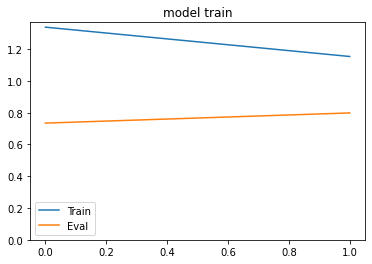

In [17]:
trainer  = Trainer(
    module_file=os.path.abspath(TRAINER_MODULE_FILE),
    examples = transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    hyperparameters=tuner.outputs['best_hyperparameters'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(splits=['train']),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'])
)
interactive_context.run(trainer)

In [18]:
interactive_context.run(trainer)

ExecutionResult(
    component_id: Trainer
    execution_id: 7
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={})
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}))

---- analysis & evaluation models

In [19]:
model_resolver = Resolver(
    strategy_class= LatestBlessedModelStrategy,
    model = Channel(type=Model),
    model_blessing = Channel(type=ModelBlessing)
).with_id('Latest_blessed_model_resolver')
 
interactive_context.run(model_resolver)

ExecutionResult(
    component_id: Latest_blessed_model_resolver
    execution_id: 8
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Latest_blessed_model_resolver, output_key=model, additional_properties={}, additional_custom_properties={})
        model_blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Latest_blessed_model_resolver, output_key=model_blessing, additional_properties={}, additional_custom_properties={}))

In [20]:
eval_config = tfma.EvalConfig(
    model_specs=[tfma.ModelSpec(label_key='dx_xf')],
    slicing_specs=[tfma.SlicingSpec()],
    metrics_specs=[
        tfma.MetricsSpec(metrics=[
            
            tfma.MetricConfig(class_name='ExampleCount'),
            tfma.MetricConfig(class_name='AUC'),
            tfma.MetricConfig(class_name='FalsePositives'),
            tfma.MetricConfig(class_name='TruePositives'),
            tfma.MetricConfig(class_name='FalseNegatives'),
            tfma.MetricConfig(class_name='TrueNegatives'),
            tfma.MetricConfig(class_name='BinaryAccuracy',
                threshold=tfma.MetricThreshold(
                    value_threshold=tfma.GenericValueThreshold(lower_bound={'value':0.5}),
                    change_threshold=tfma.GenericChangeThreshold(
                        direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                        absolute={'value':0.0001}
                    )
                )
            )
        ])
    ]
 
)

In [21]:
interactive_context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 9
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={})
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={})
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={})
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={})
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}))

In [22]:
evaluator = Evaluator(
    examples=transform.outputs['transformed_examples'],
    model=trainer.outputs['model'],
    baseline_model=model_resolver.outputs['model'],
    eval_config=eval_config)
 
interactive_context.run(evaluator)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


ExecutionResult(
    component_id: Evaluator
    execution_id: 10
    outputs:
        evaluation: OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={})
        blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={}))

In [23]:
# Visualize the evaluation results
eval_result = evaluator.outputs['evaluation'].get()[0].uri
tfma_result = tfma.load_eval_result(eval_result)
tfma.view.render_slicing_metrics(tfma_result)
tfma.addons.fairness.view.widget_view.render_fairness_indicator(
    tfma_result
)

FairnessIndicatorViewer(slicingMetrics=[{'sliceValue': 'Overall', 'slice': 'Overall', 'metrics': {'binary_accu…

---- MODEL to PUSH DEPLOYMENT

In [24]:
pusher = Pusher(
    model=trainer.outputs['model'],
    model_blessing=evaluator.outputs['blessing'],
    push_destination=pusher_pb2.PushDestination(
        filesystem=pusher_pb2.PushDestination.Filesystem(base_directory=PUSHED_MODEL_PATH)
    )
)
 
interactive_context.run(pusher)

ExecutionResult(
    component_id: Pusher
    execution_id: 11
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}))